In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from math import sqrt, cos, sin, acos, asin, atan, pi
from matplotlib import collections as mc
import numpy as np

In [2]:
def Force2Torque(force = [0,0], force_origin = [0,0], fulcrum = [0,0]):
    radius = np.array(force_origin) - np.array(fulcrum)
    torque = np.cross(radius,np.array(force))
    return torque

def Torque2Force(torque = 0, radius = 0, theta = 0, radius_rot = 0):
    if sin(theta) == 0:
        return np.zeros(2)
    force = torque / radius * sin(theta)
    force_vector = force * np.array([cos(theta-radius_rot),sin(theta-radius_rot)])
    return force_vector

class Segment:
    def __init__(self, point1 = [0,0], point2 = [0,0], mass = 0) -> None:
        self.point1 = np.array(point1)
        self.point2 = np.array(point2)
        delta = np.subtract(self.point1,self.point2)
        self.length = sqrt(np.sum(np.power(delta,2)))
        if delta[0] == 0:
            self.rot = pi/2
        else:
            self.rot = atan(delta[1]/delta[0])
        self.mass = mass
        self.centre_of_mass = np.zeros(2)
        self.UpdateCentreOfMass()
        
    @classmethod
    def from_point1(cls, point1, length, rot, mass):
        point2 = np.add(np.array(point1),np.multiply(np.array([cos(rot),sin(rot)]),length))
        return cls(point1 = point1, point2 = point2, mass = mass)
    
    @classmethod
    def from_point2(cls, point2, length, rot, mass):
        point1 = np.subtract(np.array(point2),np.multiply(np.array([cos(rot),sin(rot)]),length))
        return cls(point1 = point1, point2 = point2, mass = mass)
    
    def Point2Point(self, clockwise = True):
        if clockwise:
            self.point2 = np.add(np.array(self.point1),np.multiply(np.array([cos(self.rot),sin(self.rot)]),self.length))
        else:
            self.point1 = np.subtract(np.array(self.point2),np.multiply(np.array([cos(self.rot),sin(self.rot)]),self.length))
        self.UpdateCentreOfMass()

    def UpdateCentreOfMass(self):
        self.centre_of_mass = np.add(self.point1,np.divide(np.subtract(self.point2, self.point1),2))

    def UpdateRot(self):
        delta = np.subtract(self.point1,self.point2)
        if delta[0] == 0:
            self.rot = pi/2
        else:
            self.rot = atan(delta[1]/delta[0])
    
    def UpdateLength(self):
        delta = np.subtract(self.point1,self.point2)
        self.length = sqrt(np.sum(np.power(delta,2)))

    def Update(self, point1=None, point2=None, length=None, rot=None, mass=None):
        if point1 is not None and point2 is not None:
            self.point1 = np.array(point1)
            self.point2 = np.array(point2)
            self.UpdateCentreOfMass()
            self.UpdateLength()
            self.UpdateRot()
        elif point1 is not None and length is not None:
            self.point1 = np.array(point1)
            self.length = length
            self.Point2Point(True)
            self.UpdateCentreOfMass()
        elif point2 is not None and length is not None:
            self.point2 = np.array(point2)
            self.length = length
            self.Point2Point(False)
            self.UpdateCentreOfMass()
        elif point1 is not None and rot is not None:
            self.point1 = np.array(point1)
            self.rot = rot
            self.Point2Point(True)
            self.UpdateCentreOfMass()
        elif point2 is not None and rot is not None:
            self.point2 = np.array(point2)
            self.rot = rot
            self.Point2Point(False)
            self.UpdateCentreOfMass()
        if mass is not None:
            self.mass = mass
    
    def Translate(self, vector=[0,0]):
        delta = np.array(vector)
        self.point1 = self.point1 + delta
        self.point2 = self.point2 + delta
        self.centre_of_mass = self.centre_of_mass + delta

    def Rotate(self, angle=0, centre=[0,0]):
        s = sin(angle)
        c = cos(angle)
        cnt = np.array(centre)

        self.Translate(-cnt)
        
        x1 = self.point1[0]*c - self.point1[1]*s
        y1 = self.point1[0]*s + self.point1[1]*c

        x2 = self.point2[0]*c - self.point2[1]*s
        y2 = self.point2[0]*s + self.point2[1]*c

        self.point1 = np.array([x1,y1])
        self.point2 = np.array([x2,y2])
        
        self.Translate(cnt)
        
        self.UpdateCentreOfMass()
        self.UpdateRot()

    def __str__(self):
        return  f"{self.point1}, {self.point2}"

class Monad:
    def __init__(self, radius = 0.075, density = 1.15e3, relative_core_mass = 1.0) -> None:
        self.radius = radius
        self.density = density
        self.thickness = self.radius / 50

        self.n_faces = 18
        self.n_links = 24

        self.face_length = (2 * self.radius) / (3 * sqrt(2) - 1)
        self.face_volume = self.face_length ** 2 * self.thickness
        self.face_mass = self.face_volume * self.density

        self.link_length = self.radius * ((2 - sqrt(2)) / (3 * sqrt(2) - 1))
        self.link_width = self.face_length / 2
        self.link_volume = self.link_length * self.link_width * self.thickness
        self.link_mass = self.link_volume * self.density

        self.core_mass = (self.face_mass * self.n_faces + self.link_mass * self.n_links) * relative_core_mass

        self.mass = self.link_mass * 24 + self.face_mass * 24
        self.centre_of_mass = np.zeros(2)

        self.latch1 = Segment.from_point1([-self.face_length*1.5, self.face_length/2+self.link_length],self.face_length,pi/4,self.face_mass*2)
        self.link1 = Segment.from_point1(self.latch1.point2,self.link_length,0,self.link_mass*2)
        self.actuator1 = Segment.from_point1(self.link1.point2,self.face_length,0,self.face_mass)
        self.link2 = Segment.from_point1(self.actuator1.point2,self.link_length,0,self.link_mass*2)
        self.latch2 = Segment.from_point1(self.link2.point2,self.face_length,-pi/4,self.face_mass*2)
        #self.link9 = Segment([0,self.face_length*1.5],[0,self.face_length*1.5],self.link_mass*2)
        #self.latch5 = Segment([0,self.face_length/2+self.link_length],[0,self.face_length*1.5],self.face_mass*2)
        ########################################################################################################
        self.link3 = Segment.from_point1(self.latch2.point2,self.link_length,-pi/2,self.link_mass*2)
        self.actuator2 = Segment.from_point1(self.link3.point2,self.face_length,-pi/2,self.face_mass*4+self.link_mass*4)
        self.link4 = Segment.from_point1(self.actuator2.point2,self.link_length,-pi/2,self.link_mass*2)
        self.latch3 = Segment.from_point1(self.link4.point2,self.face_length,-pi*3/4,self.face_mass*2)
        self.link5 = Segment.from_point1(self.latch3.point2,self.link_length,-pi,self.link_mass*2)
        self.actuator3 = Segment.from_point1(self.link5.point2,self.face_length,-pi,self.face_mass)
        self.link6 = Segment.from_point1(self.actuator3.point2,self.link_length,-pi,self.link_mass*2)
        self.latch4 = Segment.from_point1(self.link6.point2,self.face_length,-pi*5/4,self.face_mass*2)
        self.link7 = Segment.from_point1(self.latch4.point2,self.link_length,-pi*3/2,self.link_mass*2)
        self.actuator4 = Segment.from_point1(self.link7.point2,self.face_length,-pi*3/2,self.face_mass*4+self.link_mass*4)
        self.link8 = Segment.from_point1(self.actuator4.point2,self.link_length,-pi*3/2,self.link_mass*2)

        self.segments_mobile = [self.latch1,
                               self.link1,
                               self.actuator1,
                               self.link2,
                               self.latch2]
        ''',
                               self.link9,
                               self.latch5]'''

        self.segments_fixed = [self.link3,
                         self.actuator2,
                         self.link4,
                         self.latch3,
                         self.link5,
                         self.actuator3,
                         self.link6,
                         self.latch4,
                         self.link7,
                         self.actuator4,
                         self.link8]

        self.lever_segment_internal = Segment(self.latch1.centre_of_mass,[0,0],0)
        self.lever_segment_external = Segment.from_point1(self.latch1.centre_of_mass,self.lever_segment_internal.length,2*self.latch1.rot-self.lever_segment_internal.rot,0)

        sumproduct_mass_centre = np.zeros(2)
        mass = 0
        
        for segment in self.segments_fixed:
            sumproduct_mass_centre = sumproduct_mass_centre + segment.centre_of_mass * segment.mass
            mass = mass + segment.mass
        
        self.static_centre_of_mass = sumproduct_mass_centre / mass
        self.static_mass = mass

        self.mobile_centre_of_mass = np.array([0,0])
        self.mobile_mass = 0

        self.UpdateCentreOfMass()


    def __str__(self):
        return f"Radius = {self.radius*1000} mm, Density = {self.density} Kg/m3\nFace length = {self.face_length*1000} mm, Link length = {self.link_length*1000}mm\nMonad mass = {self.mass} KG"

    def UpdateCentreOfMass(self):
        
        sumproduct_mass_centre_mobile = np.zeros(2)
        mobile_mass = 0
        
        for segment in self.segments_mobile:
            sumproduct_mass_centre_mobile = sumproduct_mass_centre_mobile + segment.centre_of_mass * segment.mass
            mobile_mass = mobile_mass + segment.mass
    
        total_centre_of_mass = sumproduct_mass_centre_mobile + self.static_centre_of_mass * self.static_mass
        self.mobile_centre_of_mass = sumproduct_mass_centre_mobile / mobile_mass
        self.mobile_mass = mobile_mass 
        self.centre_of_mass = total_centre_of_mass / (self.mass)


    def InverseKinematics(self, actuator_extension):
        x = self.face_length
        y = self.face_length*actuator_extension-self.link_length
        a1 = self.face_length
        a2 = self.link_length
        q2 = acos((x*x+y*y-a1*a1-a2*a2)/(2*a1*a2))
        q1 = atan(y/x)+atan(a2*sin(q2)/(a1+a2*cos(q2)))

        self.latch1.rot = q1
        self.latch1.Point2Point()
        self.link1.point1 = self.latch1.point2
        self.link1.rot = q1-q2
        self.link1.Point2Point()
        self.actuator1.point1 = self.link1.point2
        self.actuator1.Point2Point()
        self.link2.point1 = self.actuator1.point2
        self.link2.rot = 2*pi - self.link1.rot
        self.link2.Point2Point()
        self.latch2.point1 = self.link2.point2
        self.latch2.rot = 2*pi - self.latch1.rot
        self.latch2.Point2Point()
        
        '''
        self.link9.point1 = np.array([0,self.link1.point1[1]])
        self.link9.point2 = np.array([0,self.link1.point2[1]])
        self.link9.UpdateCentreOfMass()
        self.latch5.point1 = np.array([0,self.latch1.point1[1]])
        self.latch5.point2 = np.array([0,self.latch1.point2[1]])
        self.latch5.UpdateCentreOfMass()
        '''

        self.UpdateCentreOfMass()

        self.lever_segment_internal.point1 = self.latch1.centre_of_mass
        self.lever_segment_internal.point2 = self.centre_of_mass
        self.lever_segment_internal.UpdateRot()
        self.lever_segment_internal.UpdateLength()

        self.lever_segment_external.point1 = self.latch1.centre_of_mass
        self.lever_segment_external.length = self.lever_segment_internal.length
        self.lever_segment_external.rot = 2*self.latch1.rot - self.lever_segment_internal.rot
        self.lever_segment_external.Point2Point(True)
        
        return q1,q1-q2,x,y+self.link_length
    
    def Translate(self, vector=[0,0]):
        vec = np.array(vector)
        for segment in self.segments_fixed:
            segment.Translate(vec)
        for segment in self.segments_mobile:
            segment.Translate(vec)
        self.static_centre_of_mass = self.static_centre_of_mass+vec
        self.UpdateCentreOfMass()

    def Rotate(self, angle=0, centre=[0,0]):
        cnt = np.array(centre)
        theta = angle
        for segment in self.segments_fixed:
            segment.Rotate(theta, cnt)
        for segment in self.segments_mobile:
            segment.Rotate(theta, cnt)
        
        s = sin(angle)
        c = cos(angle)

        self.static_centre_of_mass = self.static_centre_of_mass - cnt
        
        x = self.static_centre_of_mass[0]*c - self.static_centre_of_mass[1]*s
        y = self.static_centre_of_mass[0]*s + self.static_centre_of_mass[1]*c

        self.static_centre_of_mass = np.array([x,y])

        self.static_centre_of_mass = self.static_centre_of_mass + cnt

        self.UpdateCentreOfMass()

            
    def ActuatorForceFormula(self, gravity = [0,-9.8]):

        gravity = np.array(gravity)
        
        latch1_torque = Force2Torque(self.latch1.mass*gravity, self.latch1.centre_of_mass, self.latch1.point1)
        monad_torque = Force2Torque(self.mass*gravity, self.lever_segment_external.point2, self.latch1.point1)
        latch2_torque = Force2Torque(self.latch2.mass*gravity, self.latch2.centre_of_mass, self.latch2.point2)

        
        latch1_force = Torque2Force(latch1_torque+monad_torque, self.latch1.length, self.latch1.rot + self.link1.rot, self.latch1.rot)
        latch2_force = Torque2Force(latch2_torque, self.latch2.length, self.latch2.rot + self.link2.rot, self.latch2.rot)
        link1_force = self.link1.mass*gravity
        link2_force = self.link2.mass*gravity
        actuator1_force = self.actuator1.mass * gravity

        actuator_force = latch1_force+link1_force+actuator1_force+latch2_force+link1_force

        return actuator_force[1]

In [3]:
monad = Monad()

(-0.13983871260923952,
 0.6031605868784244,
 -0.10132668059188371,
 0.6013266805918837)

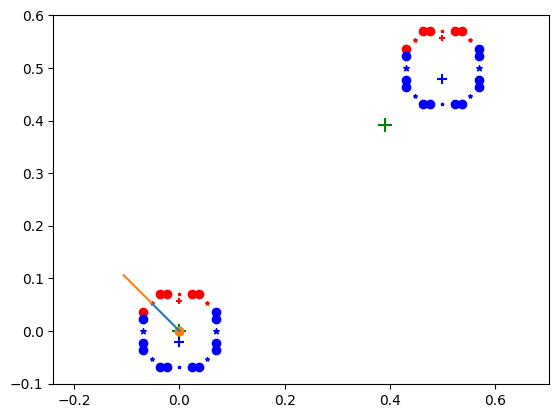

In [4]:
plt.scatter(0,0)

for segment in monad.segments_mobile:
    plt.scatter(segment.point1[0],segment.point1[1],marker='o',c='r')

for segment in monad.segments_mobile:
    plt.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='r',s=segment.mass*1000)

for segment in monad.segments_fixed:
    plt.scatter(segment.point1[0],segment.point1[1],marker='o',c='b')

for segment in monad.segments_fixed:
    plt.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='b',s=segment.mass*1000)


plt.scatter(monad.centre_of_mass[0],monad.centre_of_mass[1],marker='+',c='g',s=monad.mass*1000)
plt.scatter(monad.mobile_centre_of_mass[0],monad.mobile_centre_of_mass[1],marker='+',c='r',s=monad.mobile_mass*1000)
plt.scatter(monad.static_centre_of_mass[0],monad.static_centre_of_mass[1],marker='+',c='b',s=monad.static_mass*1000)

plt.axis('equal')

plt.plot([monad.lever_segment_internal.point1[0], monad.lever_segment_internal.point2[0]],[monad.lever_segment_internal.point1[1], monad.lever_segment_internal.point2[1]])

plt.plot([monad.lever_segment_external.point1[0], monad.lever_segment_external.point2[0]],[monad.lever_segment_external.point1[1], monad.lever_segment_external.point2[1]])

monad.Translate([0.5,0.5])

plt.scatter(0,0)

for segment in monad.segments_mobile:
    plt.scatter(segment.point1[0],segment.point1[1],marker='o',c='r')

for segment in monad.segments_mobile:
    plt.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='r',s=segment.mass*1000)

for segment in monad.segments_fixed:
    plt.scatter(segment.point1[0],segment.point1[1],marker='o',c='b')

for segment in monad.segments_fixed:
    plt.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='b',s=segment.mass*1000)


plt.scatter(monad.centre_of_mass[0],monad.centre_of_mass[1],marker='+',c='g',s=monad.mass*1000)
plt.scatter(monad.mobile_centre_of_mass[0],monad.mobile_centre_of_mass[1],marker='+',c='r',s=monad.mobile_mass*1000)
plt.scatter(monad.static_centre_of_mass[0],monad.static_centre_of_mass[1],marker='+',c='b',s=monad.static_mass*1000)

plt.axis('equal')


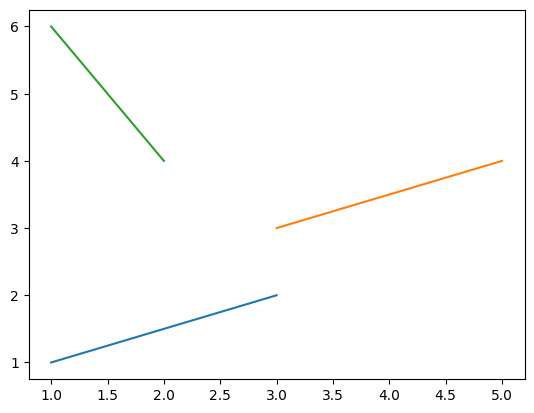

In [5]:
segment = Segment([1,1],[3,2],0)

plt.plot([segment.point1[0],segment.point2[0]],[segment.point1[1],segment.point2[1]])

segment.Translate([2,2])
 
plt.plot([segment.point1[0],segment.point2[0]],[segment.point1[1],segment.point2[1]])

segment.Rotate(pi/2,[2,3])

plt.plot([segment.point1[0],segment.point2[0]],[segment.point1[1],segment.point2[1]])

fr = [1,-1]
fo = [1,1]
fl = [0,0]

tr = Force2Torque(fr,fo,fl)
print(tr)

plt.plot([fl[0],fo[0]],[fl[1],fo[1]])
plt.plot([fo[0],fo[0]+fr[0]],[fo[1],fo[1]+fr[1]])

fv = Torque2Force(tr,0.5,-pi/3,0)
print(fv)

plt.plot([0.5,0.5+fv[0]],[0,fv[1]])


In [6]:
steps = 1000
force = np.zeros(steps)
for i in range(steps):
    monad.InverseKinematics(i/steps)
    force[i] = monad.ActuatorForceFormula([0,-9.8])

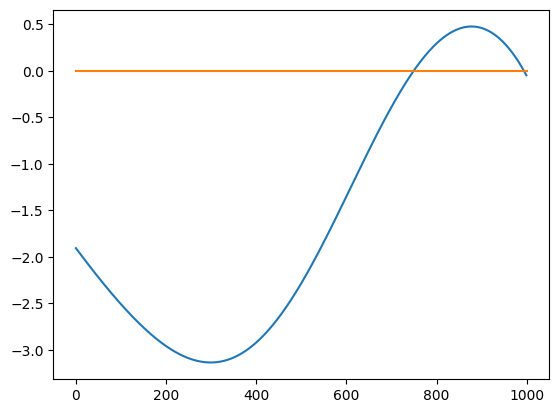

In [7]:
plt.plot(range(steps), force)
plt.plot([0,1000],[0,0])

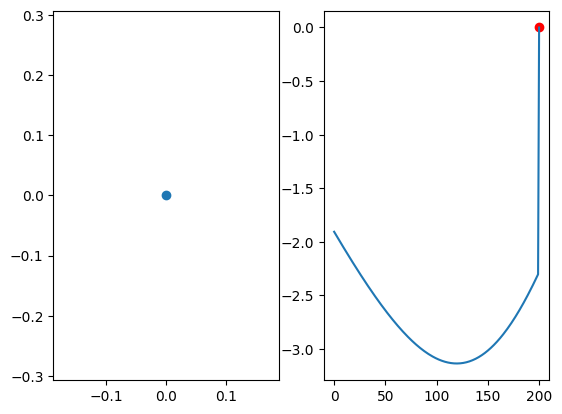

In [8]:
anim_fig = plt.figure()
steps = 400
half_steps = int(steps/2)
force = np.zeros(half_steps+1)
for i in range(half_steps):
    monad.InverseKinematics(i/steps)
    force[i] = monad.ActuatorForceFormula([0,-9.8])

def monadAnimation(actuator_position,figure, force_array, step):

    monad.InverseKinematics(actuator_position)
    
    ax1 = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)

    ax1.scatter(0,0)

    for segment in monad.segments_mobile:
        ax1.scatter(segment.point1[0],segment.point1[1],marker='o',c='r')

    for segment in monad.segments_mobile:
        ax1.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='r',s=segment.mass*1000)

    for segment in monad.segments_fixed:
        ax1.scatter(segment.point1[0],segment.point1[1],marker='o',c='b')

    for segment in monad.segments_fixed:
        ax1.scatter(segment.centre_of_mass[0],segment.centre_of_mass[1],marker='*',c='b',s=segment.mass*1000)


    ax1.scatter(monad.centre_of_mass[0],monad.centre_of_mass[1],marker='+',c='g',s=monad.mass*1000)
    ax1.scatter(monad.mobile_centre_of_mass[0],monad.mobile_centre_of_mass[1],marker='+',c='r',s=monad.mobile_mass*1000)
    ax1.scatter(monad.static_centre_of_mass[0],monad.static_centre_of_mass[1],marker='+',c='b',s=monad.static_mass*1000)

    ax1.axis('equal')
    ax1.axis([-monad.radius*2.5,monad.radius*2.5,-monad.radius*2.5,monad.radius*2.5])

    ax1.plot([monad.lever_segment_internal.point1[0], monad.lever_segment_internal.point2[0]],[monad.lever_segment_internal.point1[1], monad.lever_segment_internal.point2[1]])

    ax1.plot([monad.lever_segment_external.point1[0], monad.lever_segment_external.point2[0]],[monad.lever_segment_external.point1[1], monad.lever_segment_external.point2[1]])

    
    ax2.plot(range(half_steps+1),force_array)
    ax2.scatter(actuator_position*half_steps, force_array[int(actuator_position*half_steps)],c='r')

    return ax1,ax2

def anim_update(i):

    anim_fig.clear()
    monadAnimation(abs(half_steps-i)/half_steps,anim_fig,force,i)

anim = animation.FuncAnimation(anim_fig, anim_update, steps)
writergif = animation.PillowWriter(fps=48)
anim.save("full_monad.gif", writer=writergif)